# Задание 4.

## Transfer learning в задаче классификации изображений

В качестве датасета был ввыбран датасет https://www.kaggle.com/datasets/snmahsa/animal-image-dataset-cats-dogs-and-foxes с тремя классами: cat, dog, fox

Необходимые библиотеки

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

Подгружаем данные

In [2]:
batch_size = 32
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
dataset = datasets.ImageFolder('/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes', transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [3]:
class_names = dataset.classes

Визуализируем изображения

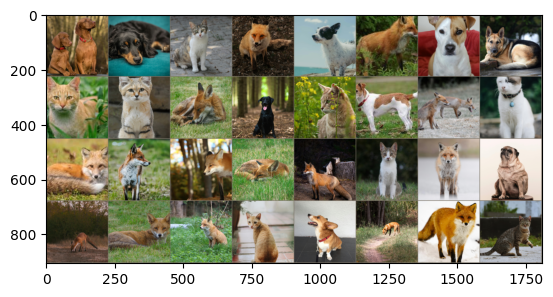

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)
imshow(out)

In [5]:
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': train_size, 'val': val_size, 'test': test_size}

Основная функция для обучения модели

In [8]:
device='cuda'
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)


        time_elapsed = time.time() - since
        print(f'Обучение завершилось за {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Лучшее значение accuracy: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

Используем модель Resnet18, поверх модели добавим классификацию на 3 класса

In [9]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# уменьшение скорости обучения по графику
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.1384 Acc: 0.4977
val Loss: 0.9677 Acc: 0.5574
Epoch 1/9
----------
train Loss: 0.7940 Acc: 0.7488
val Loss: 0.5520 Acc: 0.8852
Epoch 2/9
----------
train Loss: 0.4483 Acc: 0.9442
val Loss: 0.3544 Acc: 0.9508
Epoch 3/9
----------
train Loss: 0.2994 Acc: 0.9628
val Loss: 0.2309 Acc: 0.9672
Epoch 4/9
----------
train Loss: 0.2304 Acc: 0.9814
val Loss: 0.1734 Acc: 0.9836
Epoch 5/9
----------
train Loss: 0.1805 Acc: 0.9721
val Loss: 0.1568 Acc: 0.9672
Epoch 6/9
----------
train Loss: 0.1602 Acc: 0.9721
val Loss: 0.1450 Acc: 0.9672
Epoch 7/9
----------
train Loss: 0.1560 Acc: 0.9860
val Loss: 0.1418 Acc: 0.9672
Epoch 8/9
----------
train Loss: 0.1260 Acc: 0.9907
val Loss: 0.1364 Acc: 0.9672
Epoch 9/9
----------
train Loss: 0.1436 Acc: 0.9814
val Loss: 0.1349 Acc: 0.9836
Обучение завершилось за 13m 36s
Лучшее значение accuracy: 0.983607


Функция для визуализации

In [11]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Результаты

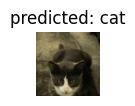

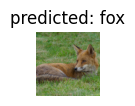

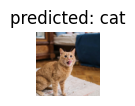

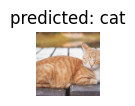

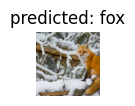

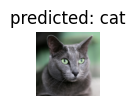

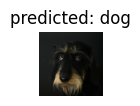

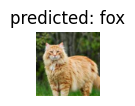

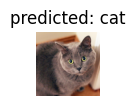

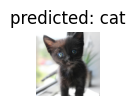

In [12]:
visualize_model(model_conv, 10)